<p style='text-align:center'>
PSY 394U <b>Methods for fMRI</b>, Fall 2019


<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Placebo_Left.png?raw=true' alt='brain blobs'/>

</p>

<p style='text-align:center; font-size:40px; margin-bottom: 30px;'><b> First-level analysis </b></p>

<p style='text-align:center; font-size:18px; margin-bottom: 32px;'><b> October 14, 2019</b></p>

<hr style='height:5px;border:none' />

# Finger-foot-lips task data
<hr style="height:1px;border:none" />

For this demonstration, we will use the test-retest data (i.e., ds114 data). Among all the fMRI data, we will focus on the **finger foot lips** task data. In brief, during this experiment, subjects were instructed to move body parts shown on the screen. In particular, they tapped fingers on the dominant hand (**hand**), flexed the dominant foot (**foot**), and pursed lips (**lips**). 

All subjects underwent the same study paradigm, for both test and re-test sessions. We can see details on the experiment from the task event data for this paradigm. 

[`<TaskInfo_fingerfootlips.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Level1/TaskInfo_fingerfootlips.py)

In [2]:
import os
import pandas as pd
from bids.layout import BIDSLayout

# Directory where your data set resides.
dataDir = '/tmp/Data/ds114'

# Creating the layout objects
layout = BIDSLayout(dataDir)


# Task events tsv file for fingerfootlips, all subjects, both sessions
taskTSV = layout.get(task='fingerfootlips',
                     suffix='events',
                     extension='tsv',
                     return_type='file')[0]

# reading the task info (as pandas data frame)
taskInfo = pd.read_csv(taskTSV, delimiter='\t')

# see whats in the task info
print(taskInfo)


    onset  duration  weight trial_type
0      10      15.0       1     Finger
1      40      15.0       1       Foot
2      70      15.0       1       Lips
3     100      15.0       1     Finger
4     130      15.0       1       Foot
5     160      15.0       1       Lips
6     190      15.0       1     Finger
7     220      15.0       1       Foot
8     250      15.0       1       Lips
9     280      15.0       1     Finger
10    310      15.0       1       Foot
11    340      15.0       1       Lips
12    370      15.0       1     Finger
13    400      15.0       1       Foot
14    430      15.0       1       Lips


As you see, the three conditions were presented in a pattern of Finger-Foot-Lips, with each condition lasting for 15s. The onset times are regularly spaced, as you can see.

# First-level analysis - single subject
<hr style="height:1px;border:none" />

## Pre-processed data

Now let us perform a first-level analysis on one of the subjects (`sub-09`). We will focus on the test session (`ses-test`). We shall use the pre-processed data by fMRIprep. If you haven't done already, you can download the tar ball of the pre-processed data from [here](https://utexas.box.com/s/88zh69bgncqda2vrf2vg0nu2ecuaw1ld). After downloading the file, put the `.tar.gz` file under the `ds114` directory of your data directory. To uncompress and unpack the data, you need to run, on your terminal (from your docker),
```
gunzip ds114_derivatives_selected.tar.gz
```
Then expand the tar ball by
```
tar -xvf ds114_derivatives_selected.tar
```
This should create a directory called **`derivatives_selected`** under `ds114` directory.


## Some pre-processing steps

The fMRI data processed with fMRIprep is normalized in the MNI space. Unfortunately fMRIprep does not perform certain pre-processing steps necessary for the first-level analysis. So we will include some pre-processing nodes in our first-level analysis script.

[`<Level1_ds114_fingerfootlips_sub-09.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Level1/Level1_ds114_fingerfootlips_sub-09.py)

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import nibabel as nib   # nibabel to read TR from image header
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms import modelgen  # GLM model generator
from nipype.interfaces.base import Bunch
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)

##### DIRECTORY BUSINESS ######
# original data directory
dataDir = '/tmp/Data/ds114'
# Output directory
outDir = os.path.join(dataDir,'WorkflowOutput')


##### PARAMETERS TO BE USED #####
nDelfMRI = 4  # number of first scans to be deleted

First, we import necessary libraries, and defined the data directory and the output directory. We also specify a parameter for the number of first fMRI time points to be deleted (**`nDelfMRI`**) as 4.

Since the pre-processed fMRI data does not reside in a BIDS-compliant directory, we have to specify the paths to the fMRI data as well as the accompanying mask image.

In [6]:
###########
#
# SPECIFYING THE FMRI DATA AND OTHER IMAGE FILES
#
###########

# directory where preprocessed fMRI data is located
baseDir = os.path.join(dataDir, 'derivatives_selected/fmriprep')
subjDir = os.path.join(baseDir, 'sub-09')
sesDir = os.path.join(subjDir, 'ses-test/func')

# location of the pre-processed fMRI & mask
# NB: Assuming that the preprocessing is done with fMRIprep
fList = os.listdir(sesDir)  # getting the directory contents
imagefMRI = [x for x in fList if
                ('task-fingerfootlips' in x) and   # fingerfootlips task
                ('preproc_bold.nii.gz' in x)][0]   # identifying the bold data
imageMask = [x for x in fList if
                ('task-fingerfootlips' in x) and   # fingerfootlips task
                ('brain_mask.nii.gz' in x)][0]   # identifying the bold data

filefMRI = os.path.join(sesDir,imagefMRI)
fileMask = os.path.join(sesDir,imageMask)

* `filefMRI`: full path to the fMRI data image file
* `fileMask`: full path to the mask image file

Now, first item of post-pre-processing steps is to delete first time points from the fMRI data.

In [7]:
# skip dummy scans
extract = Node(fsl.ExtractROI(in_file=filefMRI,  # input image full path
                              t_min=nDelfMRI,    # first volumes to be deleted
                              t_size=-1),
               name="extract")


Next, smoothing fMRI data with SUSAn.

In [8]:
# smoothing with SUSAN
susan = Node(fsl.SUSAN(brightness_threshold = 2000.0,  
                       fwhm=6.0),    # smoothing filter width (6mm, isotropic)
             name='susan')


And masking with the brain mask -- so that non-brain voxels won't be included in the analysis.

In [9]:
# masking the fMRI with a brain mask
applymask = Node(fsl.ApplyMask(mask_file=fileMask),
                 name='applymask')


## Reading and organizing the task event data

To use the task event information in the first level analysis, it needs to be organized in a certain way. First, we locate the task event data file.

In [10]:
# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# task information file
fileEvent = layout.get(suffix='events',
                       task='fingerfootlips',
                       extension='tsv',
                       return_type='file')[0]

TR is one of the necessary information setting up the first level model. You can read that information from the fMRI image header.

In [11]:
# getting TR from the image header
fMRI = nib.load(filefMRI)   # image object
hdr_fMRI = fMRI.header
TR = hdr_fMRI['pixdim'][4]

Since we have deleted a number of time points from the fMRI data, we need to adjust event onset time later. For that purpose, we calculate how many seconds the onset times need to be adjusted by multiplying TR with the number of deleted time points. This results in the offset for the onset time in terms of seconds.

In [12]:
onsetOffset = nDelfMRI * TR  # time adjustement due to deleted fMRI volumes

Now read the task event data, and get distinct conditions for this fMRI data.

In [13]:
trialInfo = pd.read_csv(fileEvent, sep='\t')
conditions = sorted(list(set(trialInfo.trial_type)))

In [14]:
conditions

['Finger', 'Foot', 'Lips']

Now, we extract onset times and stimulus durations for each of these conditions.

In [15]:
onsets = []
durations = []

for itrial in conditions:
    onsets.append(list(trialInfo[trialInfo.trial_type==itrial].onset-onsetOffset))
    durations.append(list(trialInfo[trialInfo.trial_type==itrial].duration))

Notice that the onset time is adjusted by the offset we calculated earlier. Now we have two nested lists for onset times and durations.

In [17]:
onsets

[[0.0, 90.0, 180.0, 270.0, 360.0],
 [30.0, 120.0, 210.0, 300.0, 390.0],
 [60.0, 150.0, 240.0, 330.0, 420.0]]

In [18]:
durations

[[15.0, 15.0, 15.0, 15.0, 15.0],
 [15.0, 15.0, 15.0, 15.0, 15.0],
 [15.0, 15.0, 15.0, 15.0, 15.0]]

Now the conditions, onset times, and durations are combined as an object known as a bunch.

In [19]:
subject_info = [Bunch(conditions=conditions,
                      onsets=onsets,
                      durations=durations,
                      )]

In [20]:
subject_info

[Bunch(conditions=['Finger', 'Foot', 'Lips'],
       durations=[[15.0, 15.0, 15.0, 15.0, 15.0],
        [15.0, 15.0, 15.0, 15.0, 15.0],
        [15.0, 15.0, 15.0, 15.0, 15.0]],
       onsets=[[0.0, 90.0, 180.0, 270.0, 360.0],
        [30.0, 120.0, 210.0, 300.0, 390.0],
        [60.0, 150.0, 240.0, 330.0, 420.0]])]

Now, we define contrasts we will examine later.

In [22]:
## Defining contrasts
cont01 = ['average',        'T', conditions, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', conditions, [1, 0, 0]]
cont03 = ['Foot',           'T', conditions, [0, 1, 0]]
cont04 = ['Lips',           'T', conditions, [0, 0, 1]]
cont05 = ['Finger > others','T', conditions, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', conditions, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', conditions, [-0.5, -0.5, 1]]

Each contrast is a list, as you can see. For a T contrast, these are required items:
  1. Contrast name
  2. Contrast type (`'T'` in this case, for a T-contrast)
  3. A list of conditions to be examined
  4. A vector of weights for that contrast

In [21]:
cont08 = ['activation',     'F', [cont02, cont03, cont04]]

As for an F contrast, we are examining any activation by an omnibus test of `cont02`, `cont03`, and `cont04`.

Finally, we create a list of contrasts.

In [23]:
contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08]

## Setting up the first-level analysis

Finally we can set up the actual first-level analysis. The first item is convert the experiment design into a form that can be used in subsequent steps. This is done by the **`SpecifyModel`** process available under **`nipype.algorithms.modelgen.SpecifyModel`**

In [24]:
# model specification
modelspec = Node(modelgen.SpecifyModel(subject_info=subject_info,
                                       input_units='secs',
                                       time_repetition=TR,
                                       high_pass_filter_cutoff=100),
                 name="modelspec")

Now we generate actual regressors based on the experiment design. The regressors are convolved with the HRF, and the corresponding derivative terms are also generated. This is done by the **`Level1Design`** available under **`nipype.interfaces.fsl`**.

In [25]:
# first-level design
level1design = Node(fsl.Level1Design(bases={'dgamma':{'derivs': True}},
                                     interscan_interval=TR,
                                     model_serial_correlations=True,
                                     contrasts=contrast_list),
                    name="level1design")


At this point, we generate additional necessary files to run the first-level analysis on **FEAT** in FSL, by the **`FEATModel`** process available under `nipype.interfaces.fsl`.

In [29]:
# creating all the other files necessary to run the model
modelgen = Node(fsl.FEATModel(),
                name='modelgen')

Finally, a node to run FEAT (appropriately named **`FEAT`** under `nipype.interfaces.fsl`).

In [30]:
# then running through FEAT
feat = Node(fsl.FEAT(),
            name="feat")


We also generate a datasink to collect some outputs.

In [31]:
# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=outDir),
                name='datasink')


## Setting up the workflow

Now we have all the necessary nodes, we connect them into a workflow named **`firstLevel`**. Rather than explaining every connection, I just show you the code, as well as the diagram for the workflow.

In [32]:
# creating the workflow
firstLevel = Workflow(name="Level1_FingerFootLips", base_dir=outDir)

# connecting nodes
firstLevel.connect(extract, 'roi_file', susan, 'in_file')
firstLevel.connect(susan, 'smoothed_file', applymask, 'in_file')
firstLevel.connect(applymask, 'out_file', modelspec, 'functional_runs')
firstLevel.connect(modelspec, 'session_info', level1design, 'session_info')
firstLevel.connect(level1design, 'fsf_files', modelgen, 'fsf_file')
firstLevel.connect(level1design, 'ev_files', modelgen, 'ev_files')
firstLevel.connect(level1design, 'fsf_files', feat, 'fsf_file')
firstLevel.connect(feat, 'feat_dir', datasink, 'feat_dir')
firstLevel.connect(applymask, 'out_file', datasink, 'Level1_out_file')

190927-20:33:39,24 nipype.workflow INFO:
	 Generated workflow graph: /tmp/Data/ds114/WorkflowOutput/Level1_FingerFootLips/graph_orig.png (graph2use=orig, simple_form=True).


(-0.5, 423.5, 634.5, -0.5)

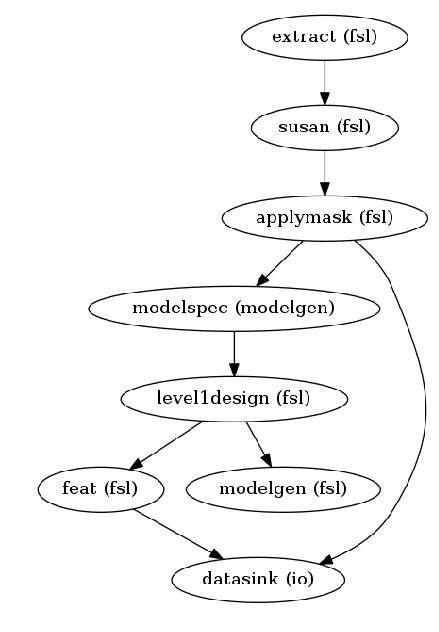

In [35]:
# writing out graphs
firstLevel.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[11,11])
img=mpimg.imread(os.path.join(outDir,"Level1_FingerFootLips","graph_orig.png"))
imgplot = plt.imshow(img)
plt.axis('off')

Now we can run the first-level analysis, the whole thing. It may take 5-10 minutes, depending on your computer.

In [36]:
# running the workflow
firstLevel.run()


190927-20:34:44,378 nipype.workflow INFO:
	 Workflow Level1_FingerFootLips settings: ['check', 'execution', 'logging', 'monitoring']
190927-20:34:44,395 nipype.workflow INFO:
	 Running serially.
190927-20:34:44,398 nipype.workflow INFO:
	 [Node] Setting-up "Level1_FingerFootLips.extract" in "/tmp/Data/ds114/WorkflowOutput/Level1_FingerFootLips/extract".
190927-20:34:44,403 nipype.workflow INFO:
	 [Node] Cached "Level1_FingerFootLips.extract" - collecting precomputed outputs
190927-20:34:44,406 nipype.workflow INFO:
	 [Node] "Level1_FingerFootLips.extract" found cached.
190927-20:34:44,407 nipype.workflow INFO:
	 [Node] Setting-up "Level1_FingerFootLips.susan" in "/tmp/Data/ds114/WorkflowOutput/Level1_FingerFootLips/susan".
190927-20:34:44,413 nipype.workflow INFO:
	 [Node] Cached "Level1_FingerFootLips.susan" - collecting precomputed outputs
190927-20:34:44,415 nipype.workflow INFO:
	 [Node] "Level1_FingerFootLips.susan" found cached.
190927-20:34:44,417 nipype.workflow INFO:
	 [Node] 

# Examining the results
<hr style="height:1px;border:none" />

To examine the results from your first-level analysis, the easiest thing to do is to examine the analysis report generated by FSL. It should be located under the directory **`run0.feat`**, inside the **`feat_dir`** directory generated from the datasink. Under `run0.feat` directory, you can find **`report.html`**. This can be opened on a web browser.

## Stats
Under **`Stats`**, you can see the design matrix, consisting of the regressors for the three conditions, as well as their temporal derivatives. The regressors are convolved by HRF, as you can see. It also shows weights for different conditions for different contrasts.

## Post-stats

Show significant activations as blobs overlaid on the fMRI data, for different conditions.